## Inicializacao

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
#from structureSelector2 import structureSelectorV2
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    index = np.where(y != 0)
    mape = round(np.mean(np.abs(residuo1[index] / y[index])) * 100, 3)
    mse = np.mean(np.square(residuo1))
    rmse = np.sqrt(mse)
    aet = np.sum(np.abs(residuo1))
    print('RMSE:', round(rmse, 4),'\nMSE:', round(mse, 4), '\nAET:', round(aet, 4), '\nMAPE:', str(round(mape, 5)) + '%')
    coeficiente_corr = np.corrcoef(y, yest)[0, 1]
    print("Coeficiente de correlação:", coeficiente_corr)
    #print(y.shape, yest.shape)

dataTank = pd.read_csv('data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,-1))
y = np.array(dataTank[['tank1', 'tank2']].T)

## Selecao de estrutura

In [85]:
#Selecione o tanque 
output = 1  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,0],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':8})
#params.append({'nb':[2,0],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':6}) #num 4
params.append({'nb':[2,2],'na':[0], 'level':1, 'nonlinear':[0,0,0,0,0, 0,0,0,0,0], 'root':True, 'delay':0})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)
print(ss)
pad = max(max(params[output]['nb']), max(params[output]['na']))
#psi, selected  = sselector.frp(vCandidatos.T, y[output, pad:], num[output], 0.000000001) #0.0000001
psi, selected  = sselector.semp(vCandidatos.T, u, y[:], params[output]['nb'], params[output]['na'], num[output], ss, output, params[output]['delay'], 0.000000001) #0.0000001

theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

#[Y1.1 U1.12 sqrtM(Y1.1)] [ 1.00029921  0.02485631 -0.04768864]
#[1 Y1.1 Y1.2 Y2.1 Y2.2 U1.9 U1.10 U1.11 U1.12 sqrtM(Y1.1) sqrtM(Y2.1) sqrtM(U1.1)]

#[1 Y1.1 Y2.1 Y2.2 sqrtM(Y1.1) sqrtM(Y2.1)]
#[Y2.1 Y2.2 Y1.1 sqrtM(Y2.1) sqrtM(Y1.1)] [ 0.6609155   0.33372277  0.00542384 -0.02214357  0.01911046]'''

[1 Y1.1 Y1.2 Y2.1 Y2.2 sqrtM(Y1.1) sqrtM(Y2.1)]
[] 0 [1] 17.223989242324674
[] 1 [Y1.1] 10.447577754055274
[] 2 [Y1.2] 10.307140915654225
[] 3 [Y2.1] 108.7520374922902
[] 4 [Y2.2] 109.18362683695354
[] 5 [sqrtM(Y1.1)] 8.407332015402202
[] 6 [sqrtM(Y2.1)] 19.261441446830194
[5] 0 [sqrtM(Y1.1) 1] 8.21200129637757
[5] 1 [sqrtM(Y1.1) Y1.1] 8.260448432110653
[5] 2 [sqrtM(Y1.1) Y1.2] 8.226217997806241
[5] 3 [sqrtM(Y1.1) Y2.1] 2.896352442058301
[5] 4 [sqrtM(Y1.1) Y2.2] 3.0661347335209683
[5] 6 [sqrtM(Y1.1) sqrtM(Y2.1)] 29.221705077679108
[5, 3] 0 [sqrtM(Y1.1) Y2.1 1] 0.18525666406149902
[5, 3] 1 [sqrtM(Y1.1) Y2.1 Y1.1] 0.21916455536395926
[5, 3] 2 [sqrtM(Y1.1) Y2.1 Y1.2] 0.2201629448698093
[5, 3] 4 [sqrtM(Y1.1) Y2.1 Y2.2] 3.150476441714984
[5, 3] 6 [sqrtM(Y1.1) Y2.1 sqrtM(Y2.1)] 0.11606444967966838
[5, 3, 6] 0 [sqrtM(Y1.1) Y2.1 sqrtM(Y2.1) 1] 0.12617436416564243
[5, 3, 6] 1 [sqrtM(Y1.1) Y2.1 sqrtM(Y2.1) Y1.1] 0.1573273547869159
[5, 3, 6] 2 [sqrtM(Y1.1) Y2.1 sqrtM(Y2.1) Y1.2] 0.157616565579876

### Simulação


Um passo a frente
RMSE: 0.1325 
MSE: 0.0176 
AET: 247.0589 
MAPE: 3.201%
Coeficiente de correlação: 0.9994921863720944

Simulação livre
RMSE: 0.2193 
MSE: 0.0481 
AET: 431.8431 
MAPE: 5.018%
Coeficiente de correlação: 0.9986202362821391


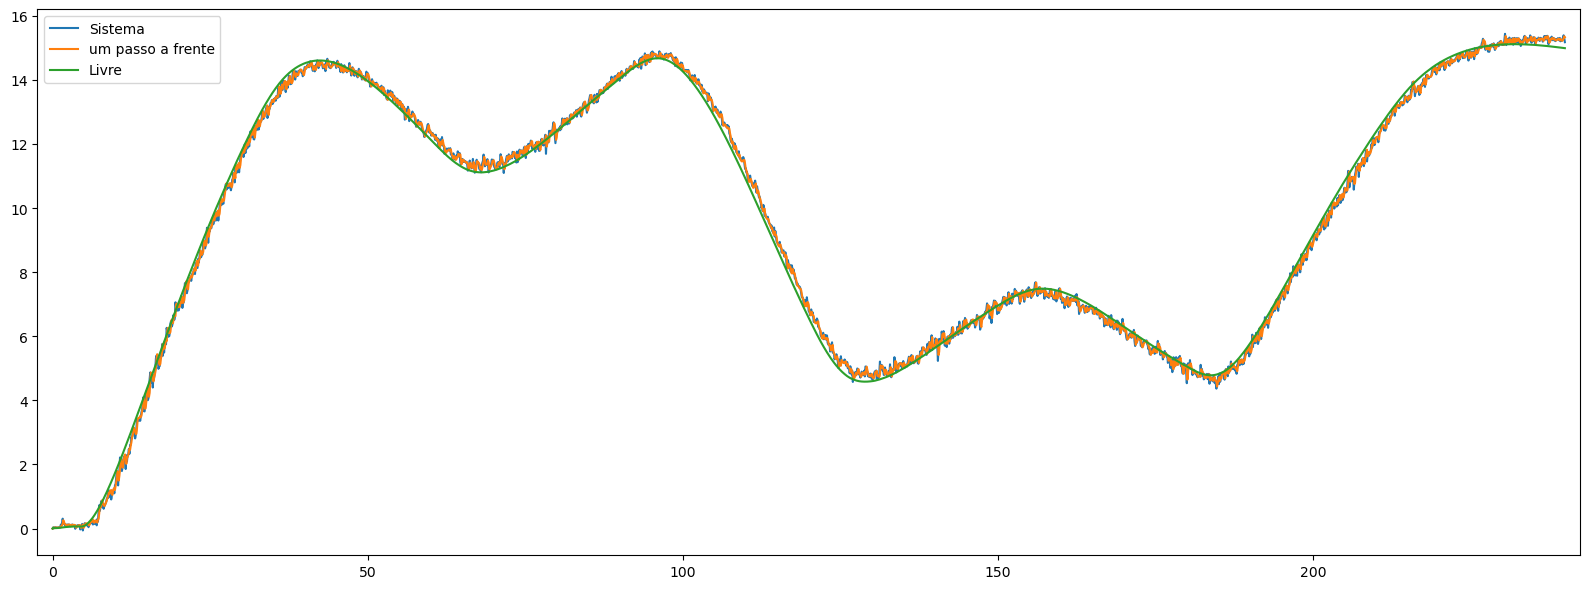

'\nSimulação livre\nRMSE: 0.378 \nMSE: 0.1429 \nAET: 775.6753 \nMAPE: 3.849%\nCoeficiente de correlação: 0.9977341830196557\n\nSimulação livre\nRMSE: 0.2453 \nMSE: 0.0602 \nAET: 489.169 \nMAPE: 2.882%\n\nSimulação livre\nRMSE: 0.3279 \nMSE: 0.1075 \nAET: 629.6969 \nMAPE: 3.319%\n'

In [89]:
slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'])
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("\nUm passo a frente")
metrics(y[output], yhat)
print("\nSimulação livre")
metrics(y[output], slivre)

l = 1.5
t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(16, 6))
#plt.title("Tanque " + str(output+1))
plt.plot(t, y[output].T, label='Sistema', linewidth=l)
plt.plot(t, yhat, label='um passo a frente', linewidth=l)
plt.plot(t, slivre, label='Livre', linewidth=l)
#plt.xlim((-5, 245))
plt.margins(x=0.01)
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/tank' + str(1 + output) + 'Est.png')

plt.show()
"""
Simulação livre
RMSE: 0.378 
MSE: 0.1429 
AET: 775.6753 
MAPE: 3.849%
Coeficiente de correlação: 0.9977341830196557

Simulação livre
RMSE: 0.2453 
MSE: 0.0602 
AET: 489.169 
MAPE: 2.882%

Simulação livre
RMSE: 0.3279 
MSE: 0.1075 
AET: 629.6969 
MAPE: 3.319%
"""

In [88]:
def recursiveMQ(y, phi, pad):
    size = phi.shape[1]
    nit = y.shape[0]
    p = 1000 * np.eye(size)
    teta = np.zeros((size, 1))

    erro = np.zeros(nit)
    print(phi.shape, nit)

    for t in range(0, nit):
        fi = phi[t,:]
        fi = fi.reshape(-1, 1)
        #print(teta, fi.T,'\n')
        erro[t] = y[t] - np.dot(teta.T, fi)
        k = np.dot(np.dot(p, fi), 1 / (1 + np.dot(np.dot(fi.T, p), fi)))
        teta = teta + np.dot(k, erro[t])
        p = p - np.dot(np.dot(k, fi.T), p)

    return np.squeeze(teta)
print(recursiveMQ(y[output][pad:], psi, pad), vCandidatos.shape, psi.shape, pad)
theta = recursiveMQ(y[output][pad:], psi, pad)

(2399, 5) 2399
[ 0.05483214  0.66019654 -0.02333796  0.33452614 -0.0522626 ] (7, 2399) (2399, 5) 2
(2399, 5) 2399


0 [1]
0 [1]


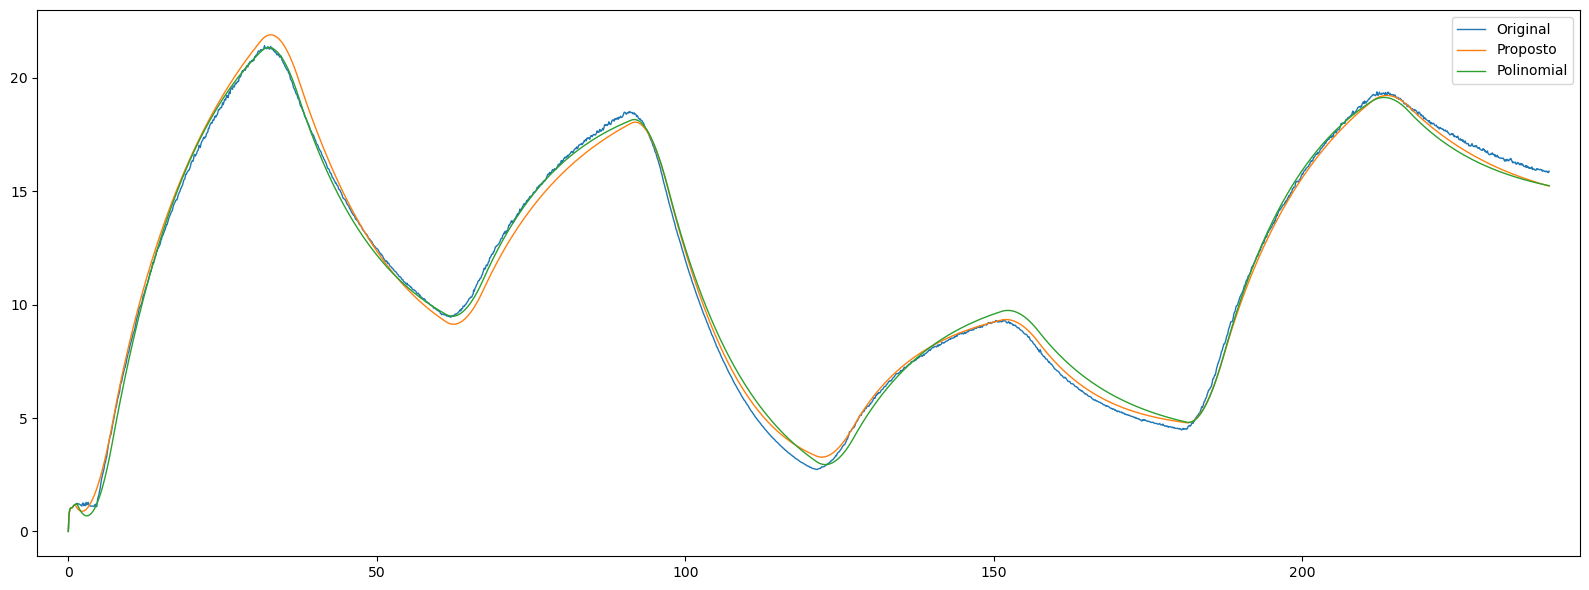

In [21]:
slivre1 = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'])
tt = []
tt.append([ 0.99289921,  0.02485943, -0.07151722]) 
tt.append([ 0.65694291,  0.33397516,  0.0574249,  -0.04870856, -0.00104841])
sm = []
sm.append([symbols("Y1.1"), symbols('U1.12'), ss[0]])
sm.append([symbols("Y2.1"), symbols("Y2.2"), symbols("Y1.1"), symbols("Y1.2"), symbols("U1.2")])

pp = []
pp.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8})
pp.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0})

slivre2 = sselector.predict(u, y, tt[output], sm[output], pp[output]['nb'], pp[output]['na'], output, pp[output]['delay'])

t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(16,6))
plt.plot(t, y[output].T, label='Original', linewidth=1.0)
plt.plot(t, slivre1, label='Proposto', linewidth=1.0)
plt.plot(t, slivre2, label='Polinomial', linewidth=1.0)
plt.xlim((-5,245))
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank2.png')

plt.show()

## Teste

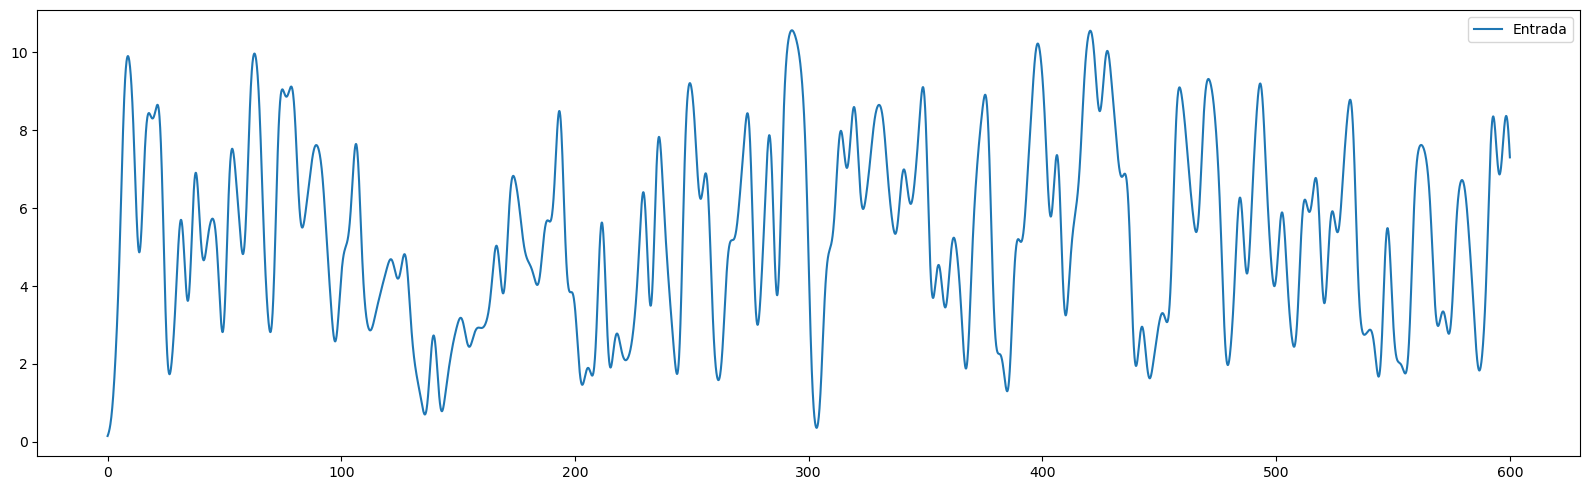

In [20]:
importFile = sc.loadmat("data/custom_input.mat")

t = importFile['V']['time'][0, 0]
custom_input = importFile['V']['values'][0, 0]

plt.figure(figsize=(16, 5))
plt.plot(t, custom_input, label='Entrada')
plt.legend()
plt.tight_layout() 
plt.show()

In [13]:
print(u.shape, y.shape)
print(uVal.shape, yVal.shape)
print(uTeste.shape, yTeste.shape)

(1, 2401) (2, 2401)
(1, 3001) (2, 3001)
(1, 6001) (1, 6001)


In [15]:
uTeste = custom_input.copy().T
yTeste = np.zeros((2, uTeste.shape[1]))
print(uTeste.shape, yTeste.shape)

valLivre = sselector.predict(uTeste, yTeste, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
#yhat = sselector.oneStepForward(custom_input, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)


(1, 6001) (2, 6001)
Simulação livre
0 [1]
input 0
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12]
Modelo selecionado:
0.0248563094786752⋅U1.12 + 1.00029920714266⋅Y1.1 - 0.0476886357675568⋅sqrtM(Y1
.1)


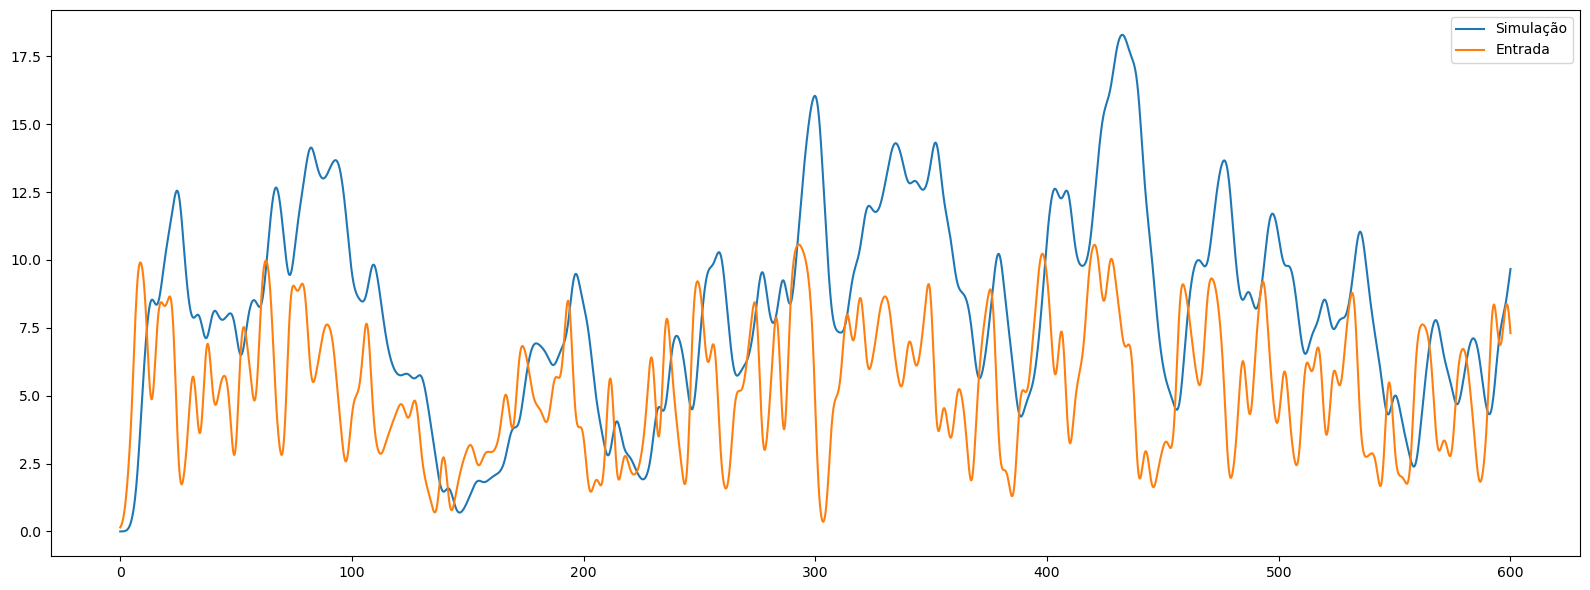

In [28]:
l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t, valLivre.T, label='Simulação', linewidth=l) #, linewidth=1.0
plt.plot(t, uTeste.T, label='Entrada', linewidth=l)
plt.tight_layout() 
plt.legend()
plt.show()

## Validação

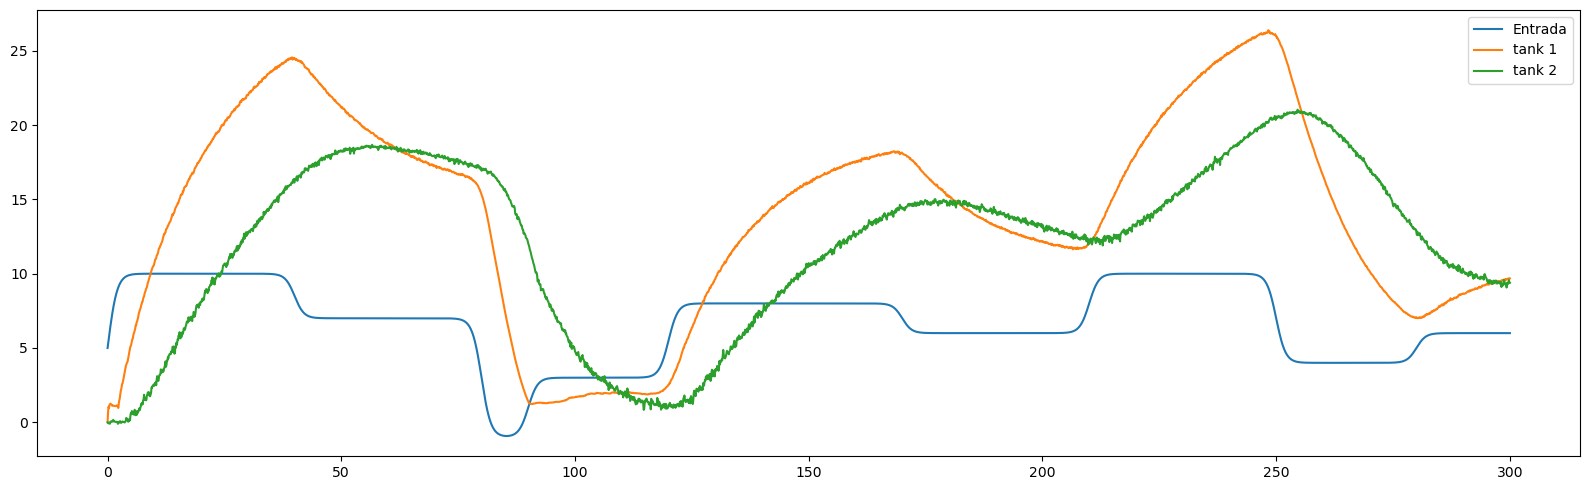

In [39]:
mat_content1 = sc.loadmat("data/ct1x1.mat")
mat_content2 = sc.loadmat("data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('data/xinput.csv')
tv = input['t']
uVal = np.array(input['v']).reshape((1,-1))


plt.figure(figsize=(16, 5))
plt.plot(tv, uVal.T, label='Entrada')
plt.plot(t1, v1, label="tank 1")
plt.plot(t2, v2, label="tank 2")
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/tankVal.png')
plt.show()

(2, 3001)
Modelo selecionado:
0.66019654283087⋅Y2.1 + 0.334526144586565⋅Y2.2 + 0.0548321379601233⋅sqrtM(Y1.1
) - 0.0233379612372118⋅sqrtM(Y2.1) - 0.0522626049177731

Um passo a frente
RMSE: 0.1236 
MSE: 0.0153 
AET: 281.2157 
MAPE: 2.501%
Coeficiente de correlação: 0.9997603898409575

Simulação livre
RMSE: 0.5571 
MSE: 0.3104 
AET: 1315.3653 
MAPE: 7.598%
Coeficiente de correlação: 0.9972470625095122


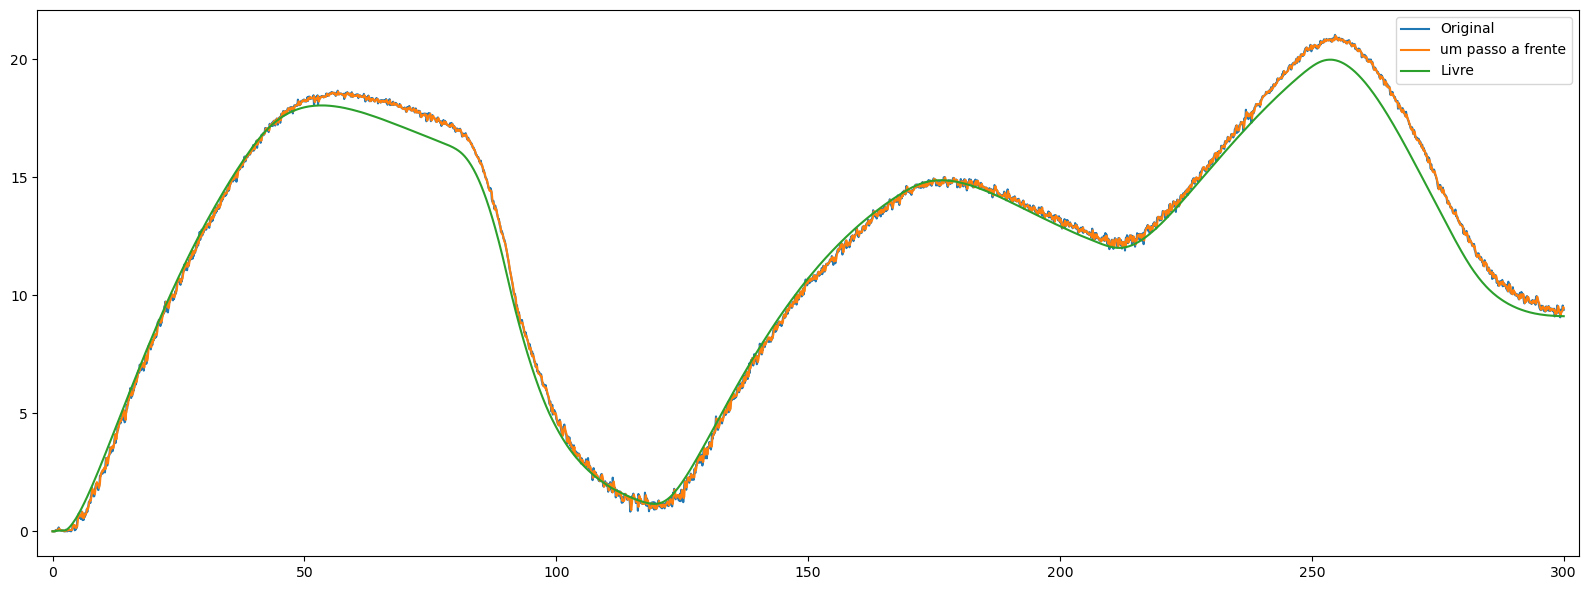

'\nSimulação livre\nRMSE: 0.6498 \nMSE: 0.4222 \nAET: 1720.6153 \nMAPE: 6.653%\nCoeficiente de correlação: 0.9973907965273143\n\nSimulação livre\nRMSE: 0.5137 \nMSE: 0.2639 \nAET: 1327.7066 \nMAPE: 5.742% u7\n'

In [90]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
#v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhatVal = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)

print("\nUm passo a frente")
metrics(yVal[output].T, yhatVal)
print("\nSimulação livre")
metrics(yVal[output].T, valLivre)

#f, ax = plt.subplots(1, 1, figsize=[24, 12])
l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t1, yVal[output].T, label='Original', linewidth=l) #, linewidth=1.0
plt.plot(t1, yhatVal, label='um passo a frente', linewidth=l)
plt.plot(t1, valLivre, label='Livre', linewidth=l)
#plt.plot(t1, ell, label='Livre', linewidth=l)

plt.margins(x=0.01)
plt.tight_layout() 
plt.legend()
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/tank1Val.png')
plt.show()
'''
Simulação livre
RMSE: 0.6498 
MSE: 0.4222 
AET: 1720.6153 
MAPE: 6.653%
Coeficiente de correlação: 0.9973907965273143

Simulação livre
RMSE: 0.5137 
MSE: 0.2639 
AET: 1327.7066 
MAPE: 5.742% u7
'''

In [31]:
ell = valLivre.copy()

0 [1]
0 [1]


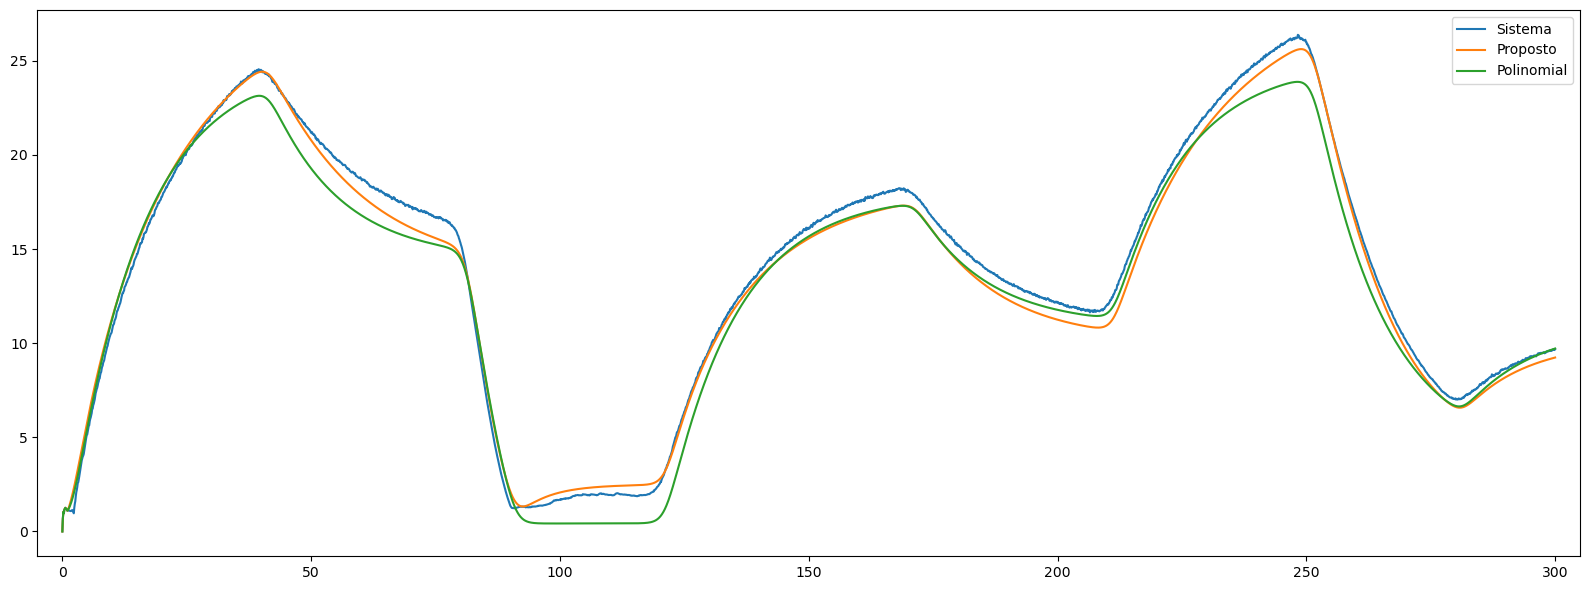

In [24]:
slivre1 = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'])
tt = [ 0.99289921,  0.02485943, -0.07151722]
sm = [symbols("Y1.1"), symbols('U1.12'), ss[0]]
slivre2 = sselector.predict(uVal, yVal, tt, sm, params[output]['nb'], params[output]['na'], output, params[output]['delay'])

l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t1, yVal[output].T, label='Sistema', linewidth=l) #
plt.plot(t1, slivre1, label='Proposto', linewidth=l)
plt.plot(t1, slivre2, label='Polinomial', linewidth=l)
plt.xlim((-5, int(t1[-1, 0]) + 5))
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank'+ str(output + 1) +'.png')
plt.show()


### a

0 [1]
0 [1]


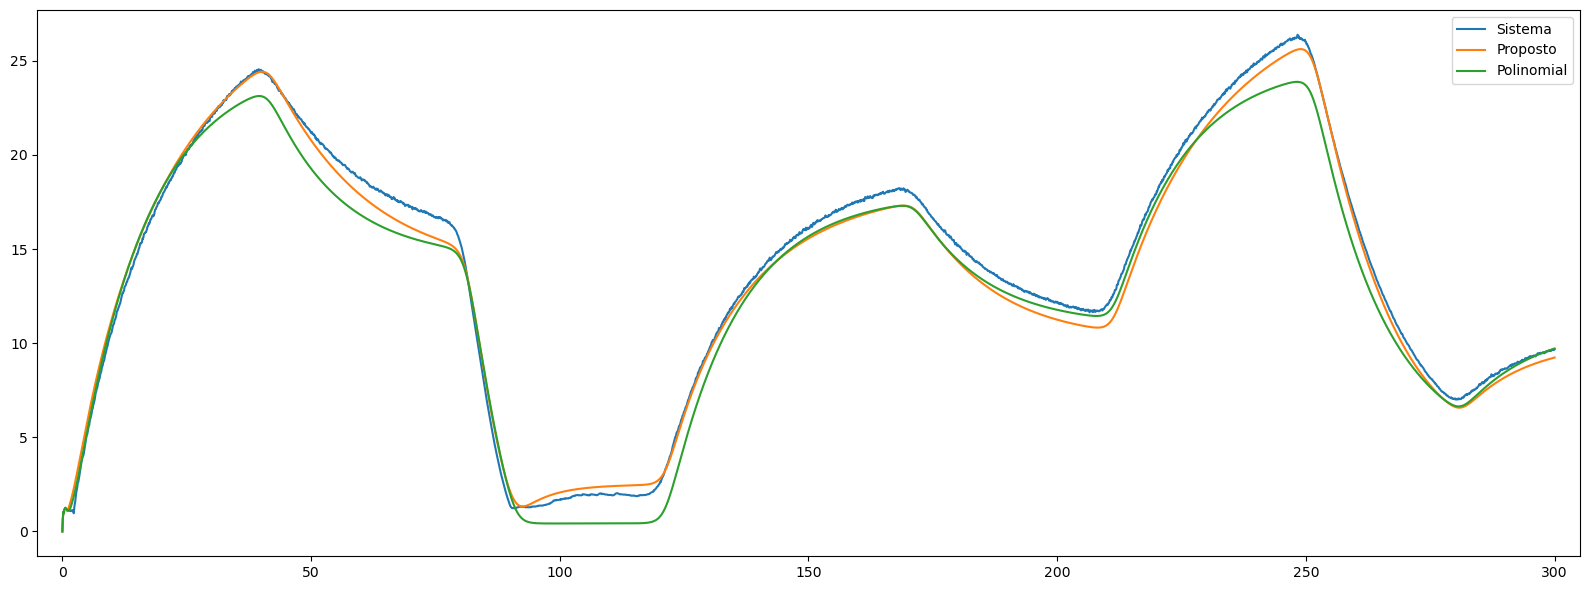

In [9]:
slivre1 = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = []
tt.append([ 0.99289921,  0.02485943, -0.07151722]) 
tt.append([ 0.65694291,  0.33397516,  0.0574249,  -0.04870856, -0.00104841])
sm = []
sm.append([symbols("Y1.1"), symbols('U1.12'), ss[0]])
sm.append([symbols("Y2.1"), symbols("Y2.2"), symbols("Y1.1"), symbols("Y1.2"), symbols("U1.2")])

pp = []
pp.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8, 'diff':False})
pp.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})

slivre2 = sselector.predict(uVal, yVal, tt[output], sm[output], pp[output]['nb'], pp[output]['na'], output, pp[output]['delay'], pp[output]['diff'], dt=0.1)

l = 1.5
t = np.arange(0, yVal.shape[1], 1) * 0.1
plt.figure(figsize=(16,6))
plt.plot(t, yVal[output].T, label='Sistema', linewidth=l)
plt.plot(t, slivre1, label='Proposto', linewidth=l)
plt.plot(t, slivre2, label='Polinomial', linewidth=l)
plt.xlim((-5, yVal.shape[1] / 10 + 5))
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank'+str(output + 1)+'.png')

plt.show()

# polinomial

In [19]:
#Selecione o tanque 
output = 1  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,0],'na':[12], 'level':1, 'delay':8})
params.append({'nb':[2,2],'na':[16], 'level':1, 'delay':10})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)
print(ss)
pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.frp(vCandidatos.T, y[output, pad:], num[output], 0.000000001) #0.0000001
#psi, selected  = sselector.semp(vCandidatos.T, u, y[:], params[output]['nb'], params[output]['na'], num[output], ss, output, params[output]['delay'], 0.000000001) #0.0000001

theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

[1 Y1.1 Y1.2 Y2.1 Y2.2 U1.11 U1.12 U1.13 U1.14 U1.15 U1.16]
[Y2.1 Y2.2 Y1.1 Y1.2 U1.11] [ 0.65700098  0.33388933  0.05631853 -0.04754981 -0.00110234]



Um passo a frente
RMSE: 0.1326 
MSE: 0.0176 
AET: 247.0427 
MAPE: 3.073%
Coeficiente de correlação: 0.9994915346901683

Simulação livre
RMSE: 0.3395 
MSE: 0.1153 
AET: 662.9002 
MAPE: 8.652%
Coeficiente de correlação: 0.9966666138456438


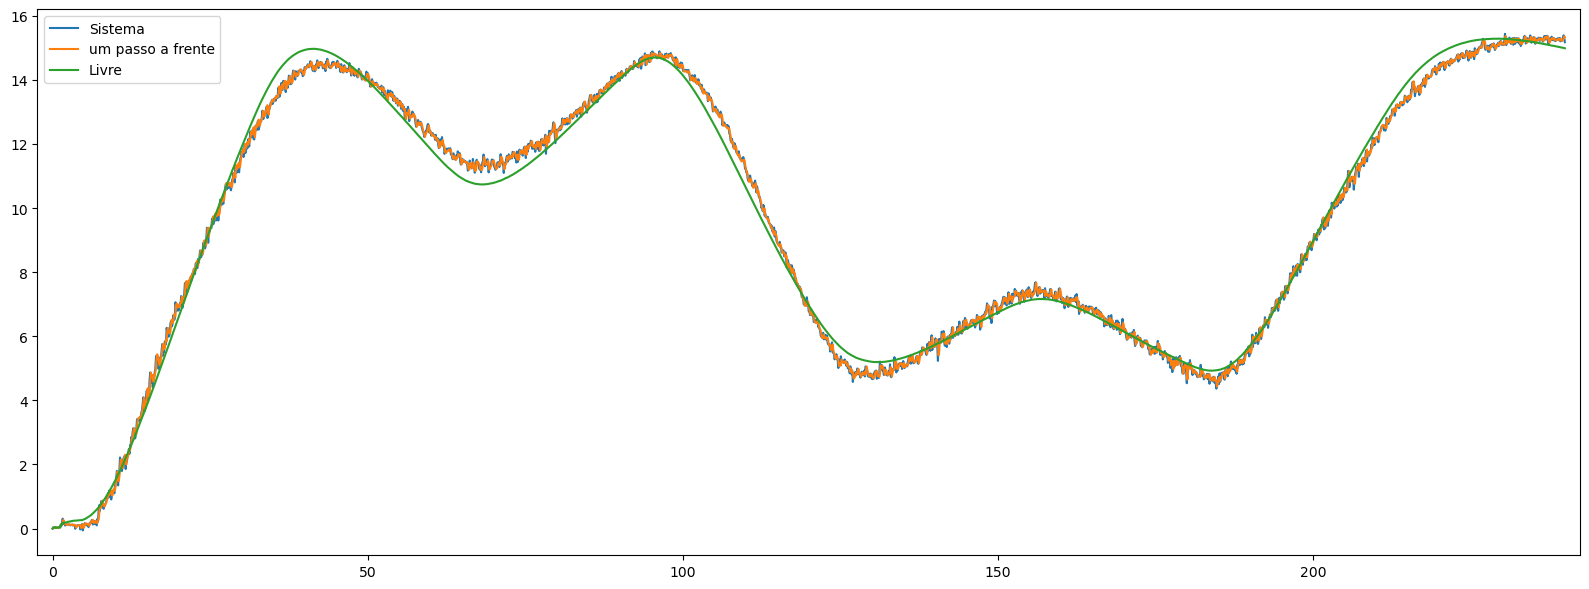

' \nSimulação livre\nRMSE: 0.3388 \nMSE: 0.1148 \nAET: 658.5194 \nMAPE: 7.491%\nCoeficiente de correlação: 0.9966848146258304'

In [20]:
slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'])
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("\nUm passo a frente")
metrics(y[output], yhat)
print("\nSimulação livre")
metrics(y[output], slivre)

l = 1.5
t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(16, 6))
#plt.title("Tanque " + str(output+1))
plt.plot(t, y[output].T, label='Sistema', linewidth=l)
plt.plot(t, yhat, label='um passo a frente', linewidth=l)
plt.plot(t, slivre, label='Livre', linewidth=l)
#plt.xlim((-5, 245))
plt.margins(x=0.01)
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/tank' + str(1 + output) + 'Est.png')

plt.show()
''' 
Simulação livre
RMSE: 0.3388 
MSE: 0.1148 
AET: 658.5194 
MAPE: 7.491%
Coeficiente de correlação: 0.9966848146258304'''